## 15.3 The Demon Algorithm

In [302]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba

- - -
#### Example: Ideal gas
- $N$ noninteracting particles of mass $m$ (an ideal gas).
- Total energy is $E = \sum_i m v_i^2/2$ where $v_i$ is the velocity of particle $i$
- - -

### Algorithm 

1. Choose a particle at random and make a trial change in its coordinates.
2. Compute $\Delta E$, the change in the energy of the system due to the change.
3. If $\Delta E \le 0$, the system gives the amount $| \Delta E|$ to the demon, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted.
4. If $\Delta E \gt 0$ and the demon has sufficient energy for this change ($E_d \ge \Delta E)$, then the demon gives the necessary energy to the system, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted. Otherwise, the trial configuration is rejected and the configuration is not changed.

Repeat.

In [652]:
class IdealDemon():
    def __init__(self, N, E):
        
        self.N = N
        self.systemEnergy = E
        self.demonEnergy = 0
        
        v0 = np.sqrt(2 * self.systemEnergy / N)
        self.v =  np.ones(self.N) * v0
        
        self.delta = 4
        
        self.reset()

    def reset(self):
        
        self.mcs = 0
        self.acceptedMoves = 0

        self.systemEnergyHistory = []        
        self.demonEnergyHistory = []

    def __str__(self):
        return f'''mcs = {self.mcs}
acceptedMoves = {self.acceptedMoves}
N = {self.N}
delta = {self.delta}
systemEnergy = {self.systemEnergy:.2f}
demonEnergy = {self.demonEnergy:.3f}
delta = {self.delta}'''
    
    def __repr__(self):
        return self.__str__()
        
    def show(self, bins=20):
        print(self)

        plt.figure()
        plt.subplot(2,1,1)
        plt.hist(self.v, bins=bins)
        plt.xlabel('v')
        plt.ylabel('number of particles')

        plt.subplot(2,1,2)
        plt.plot(self.systemEnergyHistory, label='$E$')
        plt.plot(self.demonEnergyHistory, label='$E_d$')
        plt.legend()
        plt.xlabel('mcs')
    
    def doStep(self):
        
        for j in range(self.N):
            # choose a particle at random
            particleIndex = np.random.randint(self.N)

            # random change in velocity
            dv = (2*np.random.rand() - 1)*self.delta

            trialVelocity = self.v[j] + dv
            dE = 0.5*(trialVelocity**2 - self.v[particleIndex]**2)
            
            if dE < self.demonEnergy:
                self.v[particleIndex] = trialVelocity
                self.acceptedMoves += 1
                self.systemEnergy += dE
                self.demonEnergy -= dE
        
        self.systemEnergyHistory.append(self.systemEnergy)
        self.demonEnergyHistory.append(self.demonEnergy)
        
        #increment Monte Carlo steps per particle ("time")
        self.mcs += 1
        
    def doSteps(self, m=1):
        for i in range(m):
            self.doStep()
            
    def doFastSteps(self, m=1):
        R = doSteps(m, self.N, self.v, self.delta, 
            self.mcs, self.acceptedMoves,
            self.systemEnergy, self.demonEnergy)

        (self.mcs, self.acceptedMoves, 
         self.systemEnergy, self.systemEnergyHistory,
         self.demonEnergy, self.demonEnergyHistory) = R

In [623]:
sim = IdealDemon(N=200, E=40)

In [624]:
%%time
sim.doSteps(1000)

CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


mcs = 1000
acceptedMoves = 62483
N = 200
delta = 4
systemEnergy = 39.06
demonEnergy = 0.936
delta = 4


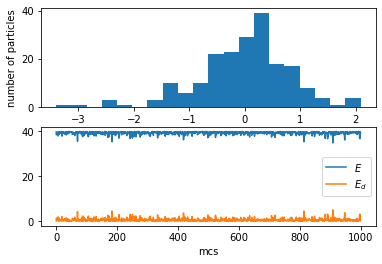

In [625]:
sim.show()

In [653]:
@numba.jit
def doSteps(m, N, v, delta, mcs, acceptedMoves,
            systemEnergy, demonEnergy):
    
    systemEnergyHistory = []
    demonEnergyHistory = []
    for i in range(m):
        for j in range(N):
            # choose a particle at random
            particleIndex = np.random.randint(N)

            # random change in velocity
            dv = (2*np.random.rand() - 1)*delta

            trialVelocity = v[j] + dv
            dE = 0.5*(trialVelocity**2 - v[particleIndex]**2)
            
            if dE < demonEnergy:
                v[particleIndex] = trialVelocity
                acceptedMoves += 1
                systemEnergy += dE
                demonEnergy -= dE

        systemEnergyHistory.append(systemEnergy)
        demonEnergyHistory.append(demonEnergy)
        mcs += 1
            
    return (mcs, acceptedMoves,
            systemEnergy, systemEnergyHistory,
            demonEnergy, demonEnergyHistory)

Explain *pass-by-value* vs *pass-by-reference*

In [654]:
%%time

R = doSteps(1000, sim.N, sim.v, sim.delta, 
            sim.mcs, sim.acceptedMoves,
            sim.systemEnergy, sim.demonEnergy)

(sim.mcs, sim.acceptedMoves, 
 sim.systemEnergy, sim.systemEnergyHistory,
 sim.demonEnergy, sim.demonEnergyHistory) = R

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 160 ms


In [655]:
sim.reset()

mcs = 0
acceptedMoves = 0
N = 1000
delta = 4
systemEnergy = 19.94
demonEnergy = 0.056
delta = 4


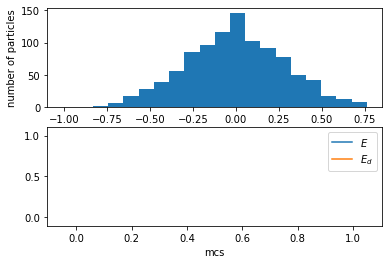

In [656]:
sim.show(bins=20)

In [657]:
sim = IdealDemon(N=1000, E=20)

In [658]:
sim.doFastSteps(10000)

In [659]:
sim.reset()

In [660]:
sim.doFastSteps(10000)

mcs = 10000
acceptedMoves = 795323
N = 1000
delta = 4
systemEnergy = 20.00
demonEnergy = 0.002
delta = 4


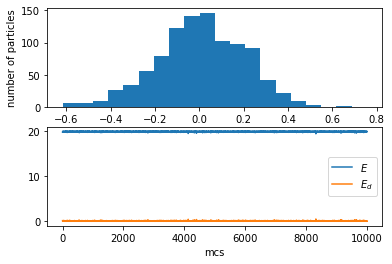

In [661]:
sim.show()

**Probelm 15.3** Demon energy distribution

In [662]:
sim.doFastSteps(5000)

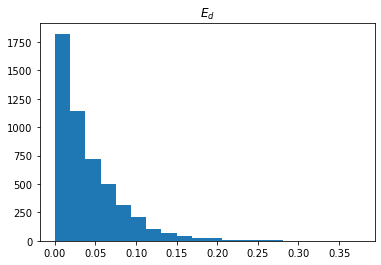

In [663]:
plt.hist(sim.demonEnergyHistory, bins=20)
plt.title('$E_d$')
plt.show()

Compute probability $P(E_d) \Delta E_d$ that the demon has energy between $E_d$ and $E_d + \Delta E_d$.

In [664]:
ΔEd = 0.01
hist, bins = np.histogram(sim.demonEnergyHistory, bins=np.arange(0, 0.25, ΔEd))

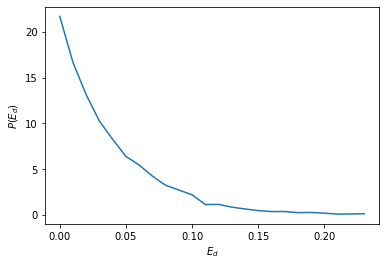

In [665]:
P = hist/np.sum(hist)/ΔEd
Ed = bins[:-1]
plt.plot( Ed, P, '-')
plt.xlabel('$E_d$')
plt.ylabel('$P(E_d)$')
plt.show()

slope = -24.446065516454187


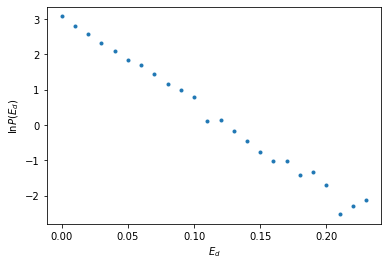

In [666]:
plt.plot(Ed, np.log(P), '.')
plt.xlabel('$E_d$')
plt.ylabel('$\ln P(E_d)$')

m, b = np.polyfit(Ed, np.log(P), 1)
print(f'slope = {m}')

inverse of absolute value of slope

In [667]:
1/abs(m)

0.04090637813790194

mean energy of the demon $\langle E_d \rangle$

In [668]:
np.mean(sim.demonEnergyHistory)

0.04131405214204149

$\frac{1}{2} m \langle v^2 \rangle = \frac{1}{2} k T_\mbox{kinetic}$

$T_\mbox{kinetic}$

In [669]:
T = np.mean(sim.v**2)
T

0.03997803073176965

mean energy per particle of the system $\langle E \rangle / N $

In [670]:
np.mean(sim.systemEnergyHistory) / sim.N

0.0199586859478576

> **Problem 15.3c** Demon energy distribution
> 
> c. Generalize the `IdealDemon` class and determine the relation between the mean demon energy, the mean energy per particle of the system, and the inverse of the slope of $\ln P(E_d)$ for an ideal gas in two and three dimensions. It is straightforward to write the class so that it is valid for any spatial dimension.

## 15.4 The Demon as Thermometer

We showed in Problem 15.3 that the form of $P(E_d)$ is given by

$$ P(E_d) \propto e^{-E_d/kT}$$

since

$$ \ln P(E_d) = -\frac{1}{kT} E_d + const.$$

Microcanonical ensemble is conceptually simple but is not a realistic situation since most systems are not isolated but in thermal contact with their environment.

Thermal contact allows energy to be exchanges between a laboratory system and its environment. The lab system is usually small compared to the environment and is commonly referred to as a *heat reservoir* or *heat bath*.

Heat refers to energy transfer due to difference in temperature. A heat bath is system for which energy transfer causes a negligible change in its temperature.

...see textbook...